In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [5]:
################## DATA FRAME ##################
datafile = 'Data/Fitbit_Kaggle/dailyActivity_merged.csv'
fields = ['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance', 
          'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 
          'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']

#pd.set_option('display.max_rows', 100)
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
selected_data = df[['Id','FairlyActiveMinutes', 'TotalSteps']]
n_rows, n_cols = df.shape
len(df['Id'].unique())

33

In [6]:
def blockRR(value, blocks, pB):
    '''
    Perform block/interval randomized response
    with prob pB the original block is kept, (1-pB) we choose a random block
    '''
    
    valB = None
    for i in range(0, len(blocks)):
        if value in blocks[i]:
            valB = i
            break
            
    if valB is None:
        valB = len(blocks)-1
    
    #print(str(value)+" "+str(valB))
    p = random.random()
    
    if p<=pB:
        privVal = random.choice(blocks[valB])
    else:
        otherVal = list()
        for j in range(0, len(blocks)):
            if j!=valB:
                otherVal.extend(blocks[j])
                
        privVal = random.choice(otherVal)
        
    return privVal

In [7]:
#Divide the rande [0,150] into buckets of 10
blocks = list()
block = list()
for i in range(0, 151):
    block.append(i)
    if len(block)>=10:
        blocks.append(block)
        block = list()
        
print(blocks)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49], [50, 51, 52, 53, 54, 55, 56, 57, 58, 59], [60, 61, 62, 63, 64, 65, 66, 67, 68, 69], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79], [80, 81, 82, 83, 84, 85, 86, 87, 88, 89], [90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [100, 101, 102, 103, 104, 105, 106, 107, 108, 109], [110, 111, 112, 113, 114, 115, 116, 117, 118, 119], [120, 121, 122, 123, 124, 125, 126, 127, 128, 129], [130, 131, 132, 133, 134, 135, 136, 137, 138, 139], [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]]


In [8]:
def sanitizeActProfile(IDs, individualAct, pB, memo=False):
    
    allPrivAct = dict()
    for Id in IDs:
        privAct = list()
        privmap = dict()
        
        if memo:
            for val in set(individualAct[Id]):
                pval = blockRR(val, blocks, pB)
                privmap[val] = pval

            for val in individualAct[Id]:
                privAct.append(privmap[val])
        else:
            for val in individualAct[Id]:
                pval = blockRR(val, blocks, pB)
                privAct.append(pval)
                
        allPrivAct[Id]=privAct
    return allPrivAct

In [9]:
IDs = selected_data['Id'].unique()
individualAct = dict()
selectedIDs = IDs
for Id in selectedIDs:
    act = selected_data[selected_data['Id']==Id]
    individualAct[Id] = act['FairlyActiveMinutes'].tolist()

In [10]:
#Sanitize without memoization
pB=0.85
sanProfiles = sanitizeActProfile(IDs,individualAct,pB)

In [11]:
#Sanitize with memoization
pB=0.85
sanProfilesM = sanitizeActProfile(IDs,individualAct,pB,True)

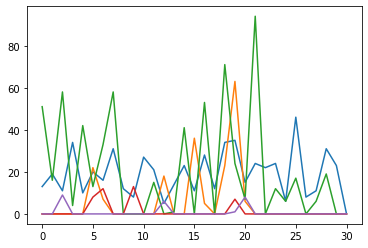

In [12]:
plotIDs = IDs[:5]
for Id in plotIDs:
    plt.plot(individualAct[Id])

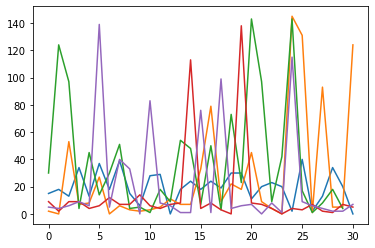

In [13]:
for Id in plotIDs:
    plt.plot(sanProfiles[Id])

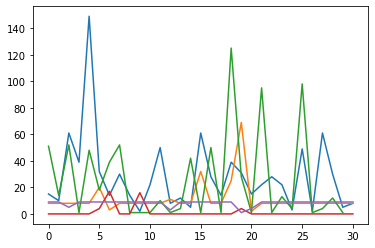

In [14]:
for Id in plotIDs:
    plt.plot(sanProfilesM[Id])

## Histogram comparison

In [15]:
orgP = list()
sanP = list()
sanPM = list()
for Id in IDs:
    orgP.extend(individualAct[Id])
    sanP.extend(sanProfiles[Id])
    sanPM.extend(sanProfilesM[Id])
    

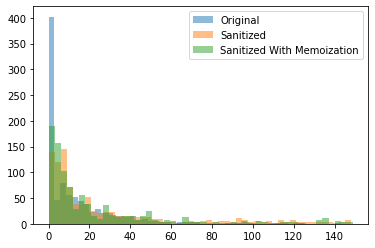

In [16]:

plt.hist(orgP, 50, alpha=0.5, label='Original')
plt.hist(sanP, 50, alpha=0.5, label='Sanitized')
plt.hist(sanPM, 50, alpha=0.5, label='Sanitized With Memoization')
plt.legend(loc='upper right')
plt.show()

## Choosing Epsilon for indistinguishability at block level

How we choose pB for a single release?

$\frac{Pr[M(b_1)=b']}{Pr[M(b_2)=b']} = \frac{p_B}{((1-p_B)/|B|-1)} <= e^\epsilon$
<br>
<br>
$p_B <= \frac{e^\epsilon}{(|B|-1+e^\epsilon)}$

where |B| = number of intervals/blocks, and \epsilon privacy parameter

In [17]:
epsilon = 5.0
B = len(blocks)
pB = math.exp(epsilon)/(B-1+math.exp(epsilon))
print(pB)

0.9138000881372063


## Choosing Epsilon for indistinguishability at value level

$\frac{Pr[M(v_1)=v']}{Pr[M(v_2)=v']} = \frac{(\frac{p_B}{m})}{((1-p_B)(\frac{1}{(n-m)})} <= e^\epsilon$
<br>
<br>
$p_B <= \frac{e^\epsilon}{(e^\epsilon+\frac{n}{m}+1)}$

where n = domain, m=size of the interval

In [18]:
epsilon = 5.0
n=max(selected_data['FairlyActiveMinutes'])
m=max(len(x) for x in blocks)
pB = math.exp(epsilon)/(math.exp(epsilon)+n/m-1)
print(pB)

0.9177556107752266


# Some Ideas
## Group indistiguishability:
Provide indistinguishability across group of individuals. For example, we can create 3 groups (non-active, medium active, very active) of users based on their activites. Then, we can modify our randomized response methods to provide indistinguishability within each group. This is a relaxed version of the privacy model, but it should improve usability.

Tasks:
1. use data drive approaches to create groups of individuals
2. measure the uniqueness in each group